select bins based on mask from stardist, bin bins to the mask centroid based on gaussian distribution

In [186]:
import sys
sys.path.append('utils')
import os
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import anndata
import geopandas as gpd

from stardist.models import StarDist2D

from tifffile import imread, imwrite
from csbdeep.utils import normalize
from shapely.geometry import Polygon, Point
from scipy import sparse
from matplotlib.colors import ListedColormap

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [187]:
gdf = gpd.read_file('../data/xenium/stardist_all.geojson')
gdf['id'] = [f"ID_{i+1}" for i, _ in enumerate(gdf.index)]
gdf.crs = None
gdf

id                                           geometry
0            ID_1  POLYGON ((2116.705 352.000, 2115.873 353.964, ...
1            ID_2  POLYGON ((2988.448 2654.000, 2988.674 2656.521...
2            ID_3  POLYGON ((2971.104 3174.000, 2970.065 3175.604...
3            ID_4  POLYGON ((3030.417 3494.000, 3029.509 3496.289...
4            ID_5  POLYGON ((3022.134 3302.000, 3021.518 3304.291...
...           ...                                                ...
216348  ID_216349  POLYGON ((27908.171 21580.000, 27907.469 21581...
216349  ID_216350  POLYGON ((28906.574 21238.000, 28907.262 21239...
216350  ID_216351  POLYGON ((27663.020 21014.000, 27662.251 21015...
216351  ID_216352  POLYGON ((28863.908 20810.000, 28864.447 20810...
216352  ID_216353  POLYGON ((28737.483 22054.000, 28737.127 22055...

[216353 rows x 2 columns]

In [188]:
import scanpy as sc
adata = sc.read_h5ad('../data/xenium/outs/transcripts_anndata_final.h5ad')
adata

AnnData object with n_obs × n_vars = 3204769 × 541
    obs: 'sample', 'start_x', 'start_y', 'end_x', 'end_y', 'center_x', 'center_y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'end_x', 'end_y', 'spatial', 'start_x', 'start_y'

In [189]:
gdf['area'] = gdf['geometry'].area

# Calculate the average area
average_area = gdf['area'].mean()

print(f'The average polygon size is: {average_area} square units')

The average polygon size is: 318.8782921648065 square units


In [190]:
import math
# Calculate the radius
average_radius = math.sqrt(average_area / math.pi)

print(f'The inferred average radius is: {average_radius} units')


The inferred average radius is: 10.074825700004002 units


In [191]:
adata_df = adata.to_df()

In [192]:
df_tissue_positions = adata_df
df_tissue_positions['index']=df_tissue_positions.index

In [193]:
# Create a GeoDataFrame from the DataFrame of coordinates
geometry = [Point(xy) for xy in zip(adata.obs['center_x'], adata.obs['center_y'])]
gdf_coordinates = gpd.GeoDataFrame(df_tissue_positions, geometry=geometry)

In [194]:
gdf.crs = None

In [195]:
result_spatial_join = gpd.sjoin(gdf_coordinates, gdf, how='left', predicate='within')

In [196]:
# Identify nuclei associated barcodes and find barcodes that are in more than one nucleus
result_spatial_join['is_within_polygon'] = ~result_spatial_join['index_right'].isna()

In [197]:
# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon']==True]


In [198]:
barcodes_in_one_polygon.shape

(532080, 547)

In [199]:
# Convert the tuples in barcodes_in_one_polygon['index'] to strings
barcodes_in_one_polygon['index'] = barcodes_in_one_polygon['index'].apply(lambda x: str(x))

# If you want to remove the 'bin' index name and set it as a regular column
barcodes_in_one_polygon.reset_index(inplace=True, drop=True)

geodataframe.py (1528): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [200]:
barcodes_in_overlaping_polygons = pd.unique(result_spatial_join[result_spatial_join.duplicated(subset=['index'])]['index'])
result_spatial_join['is_not_in_an_polygon_overlap'] = ~result_spatial_join['index'].isin(barcodes_in_overlaping_polygons)

# Remove barcodes in overlapping nuclei
barcodes_in_one_polygon = result_spatial_join[result_spatial_join['is_within_polygon'] & result_spatial_join['is_not_in_an_polygon_overlap']]

In [201]:
# The AnnData object is filtered to only contain the barcodes that are in non-overlapping polygon regions
filtered_obs_mask = adata.obs_names.isin(barcodes_in_one_polygon['index'])

In [202]:
filtered_adata = adata[filtered_obs_mask,:]

In [203]:
filtered_adata.obs

sample       start_x       start_y         end_x         end_y   
bin                                                                            
(0, 1376)    sample1   5977.914968  19691.259132   5987.326733  19700.670896  \
(0, 1400)    sample1   5977.914968  19917.141485   5987.326733  19926.553249   
(0, 1402)    sample1   5977.914968  19935.965014   5987.326733  19945.376779   
(0, 1425)    sample1   5977.914968  20152.435602   5987.326733  20161.847367   
(0, 1429)    sample1   5977.914968  20190.082661   5987.326733  20199.494426   
...              ...           ...           ...           ...           ...   
(2201, 120)  sample1  26693.209086   7870.082661  26702.620851   7879.494426   
(2201, 122)  sample1  26693.209086   7888.906190  26702.620851   7898.317955   
(2201, 123)  sample1  26693.209086   7898.317955  26702.620851   7907.729720   
(2201, 126)  sample1  26693.209086   7926.553249  26702.620851   7935.965014   
(2201, 128)  sample1  26693.209086   7945.376779  26702.620851   7954.788543   

                 center_x      center_y  n_genes_by_counts   
bin                                                          
(0, 1376)     5982.620851  19695.965014                  1  \
(0, 1400)     5982.620851  19921.847367                  1   
(0, 1402)     5982.620851  19940.670896                  2   
(0, 1425)     5982.620851  20157.141485                  1   
(0, 1429)     5982.620851  20194.788543                  1   
...                   ...           ...                ...   
(2201, 120)  26697.914968   7874.788543                  5   
(2201, 122)  26697.914968   7893.612073                  1   
(2201, 123)  26697.914968   7903.023838                  1   
(2201, 126)  26697.914968   7931.259132                  1   
(2201, 128)  26697.914968   7950.082661                  1   

             log1p_n_genes_by_counts  total_counts  log1p_total_counts   
bin                                                                      
(0, 1376)                   0.693147             1            0.693147  \
(0, 1400)                   0.693147             1            0.693147   
(0, 1402)                   1.098612             2            1.098612   
(0, 1425)                   0.693147             1            0.693147   
(0, 1429)                   0.693147             1            0.693147   
...                              ...           ...                 ...   
(2201, 120)                 1.791759             5            1.791759   
(2201, 122)                 0.693147             1            0.693147   
(2201, 123)                 0.693147             1            0.693147   
(2201, 126)                 0.693147             1            0.693147   
(2201, 128)                 0.693147             1            0.693147   

             pct_counts_in_top_50_genes  pct_counts_in_top_100_genes   
bin                                                                    
(0, 1376)                         100.0                        100.0  \
(0, 1400)                         100.0                        100.0   
(0, 1402)                         100.0                        100.0   
(0, 1425)                         100.0                        100.0   
(0, 1429)                         100.0                        100.0   
...                                 ...                          ...   
(2201, 120)                       100.0                        100.0   
(2201, 122)                       100.0                        100.0   
(2201, 123)                       100.0                        100.0   
(2201, 126)                       100.0                        100.0   
(2201, 128)                       100.0                        100.0   

             pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  
bin                                                                    
(0, 1376)                          100.0                        100.0  
(0, 1400)                          100.0          

In [204]:
import numpy as np
import pandas as pd

def fast_pdf(x):
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

def assign_transcripts_to_polygons(transcripts_df, gdf, std_dev, batch_size=1000):
    # Convert centroids to numpy array
    print('Convert centroids to numpy array')
    gdf['centroid'] = gdf['geometry'].centroid
    polygon_centroids = np.array([(p.x, p.y) for p in gdf['centroid']])
    
    # Extract transcript coordinates and counts
    print('Extract transcript coordinates and counts')
    transcript_coords = transcripts_df[['center_x', 'center_y']].values
    transcript_counts = transcripts_df['total_counts'].values

    # Precompute squared norms
    print('Precompute squared norms')
    polygon_centroids_sq = np.sum(polygon_centroids**2, axis=1)[np.newaxis, :]

    # Initialize list to collect weighted probabilities
    print('Compute distances and probabilities in batches')
    weighted_probabilities_list = []

    # Process in batches
    for i in range(0, len(transcript_coords), batch_size):
        transcript_batch = transcript_coords[i:i + batch_size]
        batch_transcript_sq = np.sum(transcript_batch**2, axis=1)[:, np.newaxis]
        batch_distances = np.sqrt(batch_transcript_sq + polygon_centroids_sq - 2 * np.dot(transcript_batch, polygon_centroids.T))
        
        # Calculate probabilities for the current batch
        batch_probabilities = fast_pdf(batch_distances / std_dev) / std_dev
        
        # Weight probabilities by transcript counts for the current batch
        batch_weighted_probabilities = batch_probabilities * transcript_counts[i:i + batch_size, np.newaxis]
        
        # Collect the weighted probabilities
        weighted_probabilities_list.append(batch_weighted_probabilities)

    # Combine weighted probabilities from all batches
    weighted_probabilities = np.vstack(weighted_probabilities_list)

    # Normalize the weighted probabilities to sum to 1
    print('Normalize the weighted probabilities to sum to 1')
    normalized_probabilities = weighted_probabilities / np.sum(weighted_probabilities, axis=1, keepdims=True)
    
    # Create a cumulative probability array for each transcript
    print('Create a cumulative probability array for each transcript')
    cumulative_probabilities = np.cumsum(normalized_probabilities, axis=1)
    
    # Generate random numbers for sampling
    random_values = np.random.rand(len(transcripts_df))
    
    # Determine chosen polygon indices
    print('Choose indices')
    chosen_polygon_indices = np.argmax(cumulative_probabilities >= random_values[:, np.newaxis], axis=1)
    
    # Assign polygon IDs to transcripts using .loc to avoid the SettingWithCopyWarning
    print('Assign polygon IDs to transcripts')
    transcripts_df.loc[:, 'assigned_polygon_id'] = gdf['id'].values[chosen_polygon_indices]
    
    return transcripts_df

def process_large_dataset_in_batches(adata_obs, gdf, std_dev, outer_batch_size=2000, inner_batch_size=1000):
    # Initialize list to collect results from each outer batch
    results_list = []

    # Process in outer batches
    for start_idx in range(0, len(adata_obs), outer_batch_size):
        end_idx = min(start_idx + outer_batch_size, len(adata_obs))
        print(f'Processing batch {start_idx} to {end_idx}')
        
        # Extract the current batch from adata_obs
        batch_obs = adata_obs.iloc[start_idx:end_idx]

        # Call assign_transcripts_to_polygons on the current batch
        batch_result = assign_transcripts_to_polygons(batch_obs, gdf, std_dev, batch_size=inner_batch_size)
        
        # Collect the result
        results_list.append(batch_result)

    # Combine results from all outer batches
    full_result = pd.concat(results_list, ignore_index=True)
    
    return full_result

# Parameters 18 (average nucleous diameter); 9 (average nucleous radius, alittle bit less) => for our polygons (average_radius)
std_dev = 4

# Example usage
transcripts_with_assignments = process_large_dataset_in_batches(filtered_adata.obs, gdf, std_dev, outer_batch_size=2000, inner_batch_size=1000)

# Save to CSV
csv_file_path = 'transcripts_with_assignments.csv'
transcripts_with_assignments.to_csv(csv_file_path, index=False)


Processing batch 0 to 2000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 2000 to 4000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 4000 to 6000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 6000 to 8000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 8000 to 10000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 10000 to 12000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 12000 to 14000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 14000 to 16000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 16000 to 18000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 18000 to 20000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 20000 to 22000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 22000 to 24000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 24000 to 26000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 26000 to 28000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 28000 to 30000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 30000 to 32000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 32000 to 34000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 34000 to 36000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 36000 to 38000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 38000 to 40000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 40000 to 42000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 42000 to 44000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 44000 to 46000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 46000 to 48000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 48000 to 50000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 50000 to 52000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 52000 to 54000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 54000 to 56000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 56000 to 58000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 58000 to 60000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 60000 to 62000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 62000 to 64000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 64000 to 66000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 66000 to 68000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 68000 to 70000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 70000 to 72000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 72000 to 74000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 74000 to 76000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 76000 to 78000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 78000 to 80000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 80000 to 82000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 82000 to 84000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 84000 to 86000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 86000 to 88000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 88000 to 90000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 90000 to 92000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 92000 to 94000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 94000 to 96000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 96000 to 98000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 98000 to 100000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 100000 to 102000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 102000 to 104000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 104000 to 106000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 106000 to 108000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 108000 to 110000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 110000 to 112000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 112000 to 114000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 114000 to 116000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 116000 to 118000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 118000 to 120000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 120000 to 122000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 122000 to 124000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 124000 to 126000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 126000 to 128000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 128000 to 130000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 130000 to 132000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 132000 to 134000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 134000 to 136000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 136000 to 138000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 138000 to 140000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 140000 to 142000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 142000 to 144000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 144000 to 146000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 146000 to 148000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 148000 to 150000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 150000 to 152000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 152000 to 154000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 154000 to 156000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 156000 to 158000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 158000 to 160000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 160000 to 162000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 162000 to 164000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 164000 to 166000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 166000 to 168000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 168000 to 170000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 170000 to 172000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 172000 to 174000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 174000 to 176000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 176000 to 178000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 178000 to 180000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 180000 to 182000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 182000 to 184000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 184000 to 186000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 186000 to 188000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 188000 to 190000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 190000 to 192000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 192000 to 194000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 194000 to 196000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 196000 to 198000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 198000 to 200000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 200000 to 202000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 202000 to 204000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 204000 to 206000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 206000 to 208000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 208000 to 210000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 210000 to 212000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 212000 to 214000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 214000 to 216000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 216000 to 218000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 218000 to 220000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 220000 to 222000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 222000 to 224000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 224000 to 226000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 226000 to 228000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 228000 to 230000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 230000 to 232000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 232000 to 234000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 234000 to 236000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 236000 to 238000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 238000 to 240000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 240000 to 242000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 242000 to 244000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 244000 to 246000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 246000 to 248000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 248000 to 250000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 250000 to 252000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 252000 to 254000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 254000 to 256000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 256000 to 258000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 258000 to 260000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 260000 to 262000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 262000 to 264000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 264000 to 266000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 266000 to 268000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 268000 to 270000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 270000 to 272000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 272000 to 274000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 274000 to 276000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 276000 to 278000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 278000 to 280000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 280000 to 282000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 282000 to 284000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 284000 to 286000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 286000 to 288000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 288000 to 290000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 290000 to 292000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 292000 to 294000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 294000 to 296000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 296000 to 298000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 298000 to 300000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 300000 to 302000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 302000 to 304000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 304000 to 306000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 306000 to 308000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 308000 to 310000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 310000 to 312000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 312000 to 314000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 314000 to 316000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 316000 to 318000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 318000 to 320000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 320000 to 322000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 322000 to 324000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 324000 to 326000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 326000 to 328000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 328000 to 330000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 330000 to 332000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 332000 to 334000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 334000 to 336000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 336000 to 338000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 338000 to 340000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 340000 to 342000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 342000 to 344000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 344000 to 346000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 346000 to 348000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 348000 to 350000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 350000 to 352000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 352000 to 354000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 354000 to 356000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 356000 to 358000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 358000 to 360000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 360000 to 362000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 362000 to 364000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 364000 to 366000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 366000 to 368000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 368000 to 370000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 370000 to 372000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 372000 to 374000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 374000 to 376000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 376000 to 378000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 378000 to 380000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 380000 to 382000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 382000 to 384000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 384000 to 386000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 386000 to 388000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 388000 to 390000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 390000 to 392000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts
Processing batch 392000 to 394000
Convert centroids to numpy array


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 394000 to 396000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 396000 to 398000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 398000 to 400000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 400000 to 402000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 402000 to 404000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 404000 to 406000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 406000 to 408000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 408000 to 410000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 410000 to 412000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 412000 to 414000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 414000 to 416000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 416000 to 418000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 418000 to 420000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 420000 to 422000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 422000 to 424000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 424000 to 426000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 426000 to 428000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 428000 to 430000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 430000 to 432000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 432000 to 434000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 434000 to 436000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 436000 to 438000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 438000 to 440000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 440000 to 442000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 442000 to 444000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 444000 to 446000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 446000 to 448000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 448000 to 450000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 450000 to 452000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 452000 to 454000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 454000 to 456000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 456000 to 458000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 458000 to 460000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 460000 to 462000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 462000 to 464000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 464000 to 466000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 466000 to 468000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 468000 to 470000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 470000 to 472000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 472000 to 474000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 474000 to 476000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 476000 to 478000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 478000 to 480000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 480000 to 482000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 482000 to 484000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 484000 to 486000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 486000 to 488000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 488000 to 490000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 490000 to 492000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 492000 to 494000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 494000 to 496000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 496000 to 498000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 498000 to 500000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 500000 to 502000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 502000 to 504000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 504000 to 506000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 506000 to 508000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 508000 to 510000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 510000 to 512000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 512000 to 514000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 514000 to 516000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 516000 to 518000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 518000 to 520000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 520000 to 522000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 522000 to 524000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 524000 to 526000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 526000 to 528000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 528000 to 530000
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Processing batch 530000 to 531974
Convert centroids to numpy array
Extract transcript coordinates and counts
Precompute squared norms
Compute distances and probabilities in batches
Normalize the weighted probabilities to sum to 1
Create a cumulative probability array for each transcript
Choose indices
Assign polygon IDs to transcripts


1808158519.py (61): 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [205]:
print(f"Length of filtered_adata.obs: {len(filtered_adata.obs)}")
print(f"Length of barcodes_in_one_polygon: {len(barcodes_in_one_polygon)}")
print(f"Length of transcripts_with_assignments: {len(transcripts_with_assignments)}")

Length of filtered_adata.obs: 531974
Length of barcodes_in_one_polygon: 531974
Length of transcripts_with_assignments: 531974


In [206]:
filtered_adata.obs.head()

sample      start_x       start_y        end_x         end_y   
bin                                                                        
(0, 1376)  sample1  5977.914968  19691.259132  5987.326733  19700.670896  \
(0, 1400)  sample1  5977.914968  19917.141485  5987.326733  19926.553249   
(0, 1402)  sample1  5977.914968  19935.965014  5987.326733  19945.376779   
(0, 1425)  sample1  5977.914968  20152.435602  5987.326733  20161.847367   
(0, 1429)  sample1  5977.914968  20190.082661  5987.326733  20199.494426   

              center_x      center_y  n_genes_by_counts   
bin                                                       
(0, 1376)  5982.620851  19695.965014                  1  \
(0, 1400)  5982.620851  19921.847367                  1   
(0, 1402)  5982.620851  19940.670896                  2   
(0, 1425)  5982.620851  20157.141485                  1   
(0, 1429)  5982.620851  20194.788543                  1   

           log1p_n_genes_by_counts  total_counts  log1p_total_counts   
bin                                                                    
(0, 1376)                 0.693147             1            0.693147  \
(0, 1400)                 0.693147             1            0.693147   
(0, 1402)                 1.098612             2            1.098612   
(0, 1425)                 0.693147             1            0.693147   
(0, 1429)                 0.693147             1            0.693147   

           pct_counts_in_top_50_genes  pct_counts_in_top_100_genes   
bin                                                                  
(0, 1376)                       100.0                        100.0  \
(0, 1400)                       100.0                        100.0   
(0, 1402)                       100.0                        100.0   
(0, 1425)                       100.0                        100.0   
(0, 1429)                       100.0                        100.0   

           pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  
bin                                                                  
(0, 1376)                        100.0                        100.0  
(0, 1400)                        100.0                        100.0  
(0, 1402)                        100.0                        100.0  
(0, 1425)                        100.0                        100.0  
(0, 1429)                        100.0                        100.0

In [207]:
transcripts_with_assignments.head()

sample      start_x       start_y        end_x         end_y     center_x   
0  sample1  5977.914968  19691.259132  5987.326733  19700.670896  5982.620851  \
1  sample1  5977.914968  19917.141485  5987.326733  19926.553249  5982.620851   
2  sample1  5977.914968  19935.965014  5987.326733  19945.376779  5982.620851   
3  sample1  5977.914968  20152.435602  5987.326733  20161.847367  5982.620851   
4  sample1  5977.914968  20190.082661  5987.326733  20199.494426  5982.620851   

       center_y  n_genes_by_counts  log1p_n_genes_by_counts  total_counts   
0  19695.965014                  1                 0.693147             1  \
1  19921.847367                  1                 0.693147             1   
2  19940.670896                  2                 1.098612             2   
3  20157.141485                  1                 0.693147             1   
4  20194.788543                  1                 0.693147             1   

   log1p_total_counts  pct_counts_in_top_50_genes   
0            0.693147                       100.0  \
1            0.693147                       100.0   
2            1.098612                       100.0   
3            0.693147                       100.0   
4            0.693147                       100.0   

   pct_counts_in_top_100_genes  pct_counts_in_top_200_genes   
0                        100.0                        100.0  \
1                        100.0                        100.0   
2                        100.0                        100.0   
3                        100.0                        100.0   
4                        100.0                        100.0   

   pct_counts_in_top_500_genes assigned_polygon_id  
0                        100.0           ID_161811  
1                        100.0           ID_157934  
2                        100.0           ID_163657  
3                        100.0           ID_161230  
4                        100.0           ID_163362

In [208]:
filtered_adata.obs['id'] = transcripts_with_assignments['assigned_polygon_id'].values

1503748785.py (1): Trying to modify attribute `.obs` of view, initializing view as actual.


In [209]:
filtered_adata.obs

sample       start_x       start_y         end_x         end_y   
bin                                                                            
(0, 1376)    sample1   5977.914968  19691.259132   5987.326733  19700.670896  \
(0, 1400)    sample1   5977.914968  19917.141485   5987.326733  19926.553249   
(0, 1402)    sample1   5977.914968  19935.965014   5987.326733  19945.376779   
(0, 1425)    sample1   5977.914968  20152.435602   5987.326733  20161.847367   
(0, 1429)    sample1   5977.914968  20190.082661   5987.326733  20199.494426   
...              ...           ...           ...           ...           ...   
(2201, 120)  sample1  26693.209086   7870.082661  26702.620851   7879.494426   
(2201, 122)  sample1  26693.209086   7888.906190  26702.620851   7898.317955   
(2201, 123)  sample1  26693.209086   7898.317955  26702.620851   7907.729720   
(2201, 126)  sample1  26693.209086   7926.553249  26702.620851   7935.965014   
(2201, 128)  sample1  26693.209086   7945.376779  26702.620851   7954.788543   

                 center_x      center_y  n_genes_by_counts   
bin                                                          
(0, 1376)     5982.620851  19695.965014                  1  \
(0, 1400)     5982.620851  19921.847367                  1   
(0, 1402)     5982.620851  19940.670896                  2   
(0, 1425)     5982.620851  20157.141485                  1   
(0, 1429)     5982.620851  20194.788543                  1   
...                   ...           ...                ...   
(2201, 120)  26697.914968   7874.788543                  5   
(2201, 122)  26697.914968   7893.612073                  1   
(2201, 123)  26697.914968   7903.023838                  1   
(2201, 126)  26697.914968   7931.259132                  1   
(2201, 128)  26697.914968   7950.082661                  1   

             log1p_n_genes_by_counts  total_counts  log1p_total_counts   
bin                                                                      
(0, 1376)                   0.693147             1            0.693147  \
(0, 1400)                   0.693147             1            0.693147   
(0, 1402)                   1.098612             2            1.098612   
(0, 1425)                   0.693147             1            0.693147   
(0, 1429)                   0.693147             1            0.693147   
...                              ...           ...                 ...   
(2201, 120)                 1.791759             5            1.791759   
(2201, 122)                 0.693147             1            0.693147   
(2201, 123)                 0.693147             1            0.693147   
(2201, 126)                 0.693147             1            0.693147   
(2201, 128)                 0.693147             1            0.693147   

             pct_counts_in_top_50_genes  pct_counts_in_top_100_genes   
bin                                                                    
(0, 1376)                         100.0                        100.0  \
(0, 1400)                         100.0                        100.0   
(0, 1402)                         100.0                        100.0   
(0, 1425)                         100.0                        100.0   
(0, 1429)                         100.0                        100.0   
...                                 ...                          ...   
(2201, 120)                       100.0                        100.0   
(2201, 122)                       100.0                        100.0   
(2201, 123)                       100.0                        100.0   
(2201, 126)                       100.0                        100.0   
(2201, 128)                       100.0                        100.0   

             pct_counts_in_top_200_genes  pct_counts_in_top_500_genes   
bin                                                                     
(0, 1376)                          100.0                        100.0  \
(0, 1400)                          100.0       

In [210]:
filtered_adata.write('../data/xenium/outs/stardist_gaussian.h5ad')

In [211]:
print(filtered_adata.obs.index[:5])  # Print first few indices from filtered_adata.obs
print(barcodes_in_one_polygon['index'][:5])  # Print first few indices from barcodes_in_one_polygon

Index(['(0, 1376)', '(0, 1400)', '(0, 1402)', '(0, 1425)', '(0, 1429)'], dtype='object', name='bin')
bin
(0, 1376)    (0, 1376)
(0, 1400)    (0, 1400)
(0, 1402)    (0, 1402)
(0, 1425)    (0, 1425)
(0, 1429)    (0, 1429)
Name: index, dtype: object


In [212]:
# Group the data by unique nucleous IDs
groupby_object = filtered_adata.obs.groupby(['id'], observed=True)

In [213]:
# Extract the gene expression counts from the AnnData object
counts = filtered_adata.X

# Obtain the number of unique nuclei and the number of genes in the expression data
N_groups = groupby_object.ngroups
N_genes = counts.shape[1]

# Initialize a sparse matrix to store the summed gene counts for each nucleus
summed_counts = sparse.lil_matrix((N_groups, N_genes))

# Lists to store the IDs of polygons and the current row index
polygon_id = []
row = 0

# Iterate over each unique polygon to calculate the sum of gene counts.
for polygons, idx_ in groupby_object.indices.items():
    summed_counts[row] = counts[idx_].sum(0)
    row += 1
    polygon_id.append(polygons)

# Create and AnnData object from the summed count matrix
summed_counts = summed_counts.tocsr()
grouped_filtered_adata = anndata.AnnData(X=summed_counts,obs=pd.DataFrame(polygon_id,columns=['id'],index=polygon_id),var=filtered_adata.var)

%store grouped_filtered_adata


Stored 'grouped_filtered_adata' (AnnData)


In [214]:
grouped_filtered_adata

AnnData object with n_obs × n_vars = 147621 × 541
    obs: 'id'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [215]:
# Create a mask based on the 'id' column for values present in 'gdf' with 'area' less than 500
#mask_area = grouped_filtered_adata.obs['id'].isin(gdf[(gdf['area'] < 3000)].id)

# Create a mask based on the 'total_counts' column for values greater than 100
#ask_count = grouped_filtered_adata.obs['total_counts'] > 100

# Apply both masks to the original AnnData to create a new filtered AnnData object
count_area_filtered_adata = grouped_filtered_adata

# Calculate quality control metrics for the filtered AnnData object
sc.pp.calculate_qc_metrics(count_area_filtered_adata, inplace=True)


In [216]:
 # Normalize total counts for each cell in the AnnData object
sc.pp.normalize_total(count_area_filtered_adata, inplace=True)

# Logarithmize the values in the AnnData object after normalization
sc.pp.log1p(count_area_filtered_adata)

# Identify highly variable genes in the dataset using the Seurat method
sc.pp.highly_variable_genes(count_area_filtered_adata, flavor="seurat", n_top_genes=2000)

# Perform Principal Component Analysis (PCA) on the AnnData object
sc.pp.pca(count_area_filtered_adata)

# Build a neighborhood graph based on PCA components
sc.pp.neighbors(count_area_filtered_adata)

# Perform Leiden clustering on the neighborhood graph and store the results in 'clusters' column

# Adjust the resolution parameter as needed for different samples
#sc.tl.leiden(count_area_filtered_adata, resolution=0.4, key_added="clusters")


_index.py (146): Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


In [217]:
sc.tl.leiden(count_area_filtered_adata, resolution=0.4, key_added="clusters")

In [97]:
import imageio

# Load the image
img = imageio.imread('../data/xenium/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif')

268951726.py (4): Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


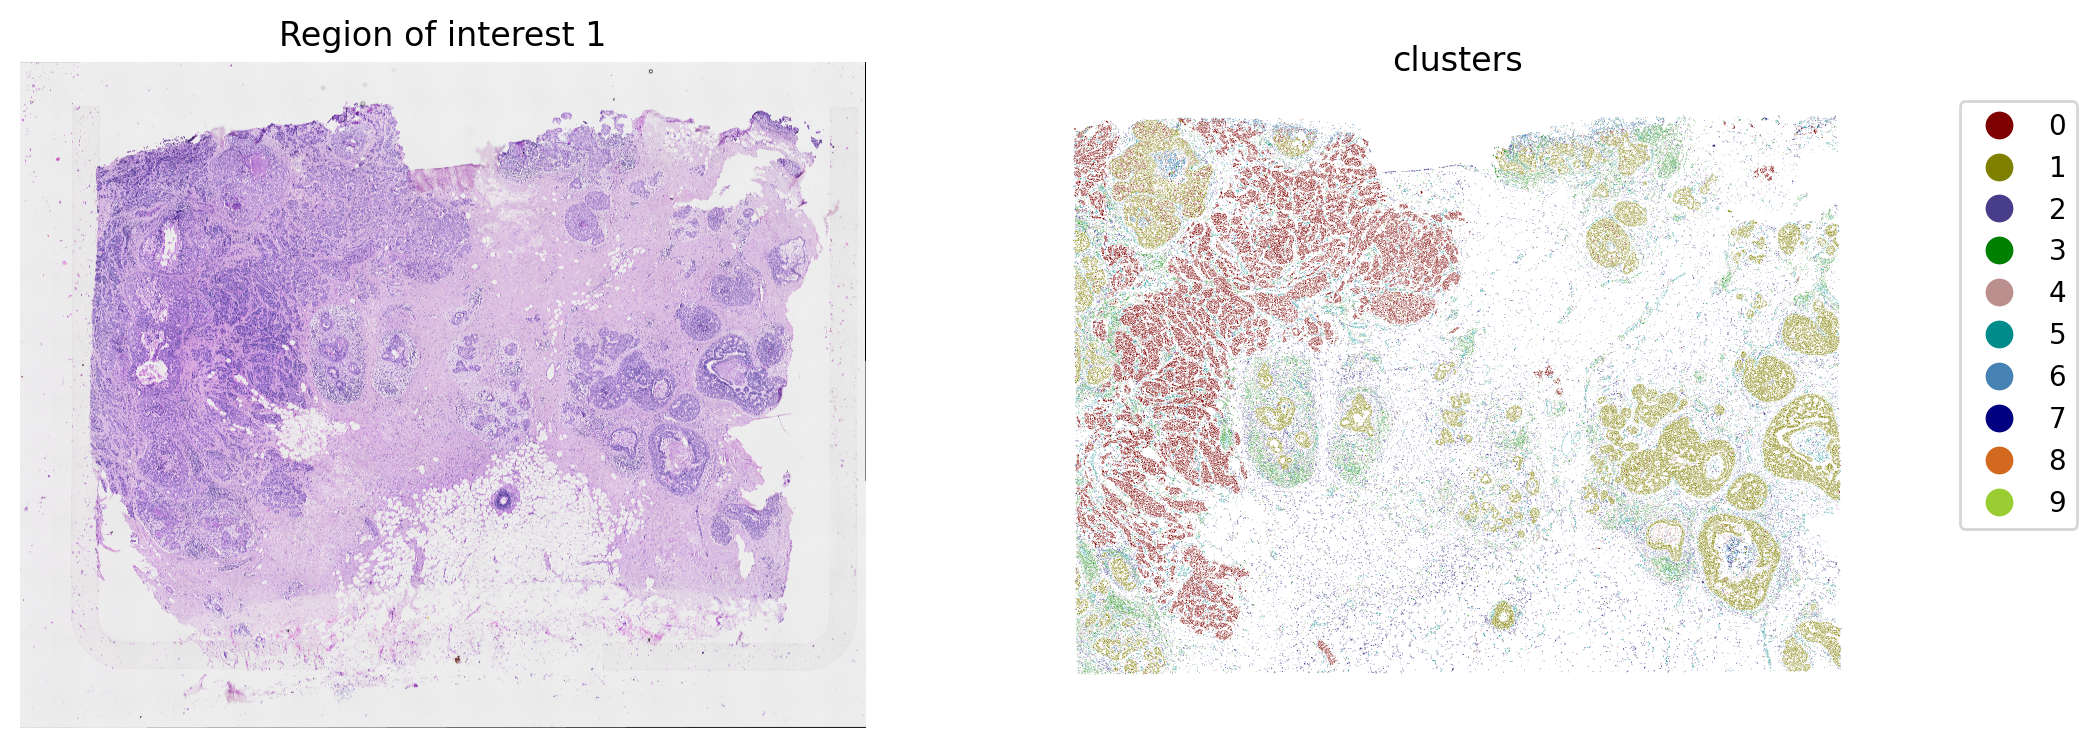

In [98]:
import sys
sys.path.append('../src/utils')
import os
import importlib
import image_plot_utils
importlib.reload(image_plot_utils)
from image_plot_utils import plot_clusters_and_save_image
# Plot and save the clustering results
plot_clusters_and_save_image(title="Region of interest 1", gdf=gdf, img=img, adata=count_area_filtered_adata, color_by_obs='clusters', output_name="image_clustering.ROI1.tiff")

In [218]:
merged_gdf = gdf.merge(count_area_filtered_adata.obs['clusters'].astype('category'), left_on='id', right_index=True)

<Axes: >

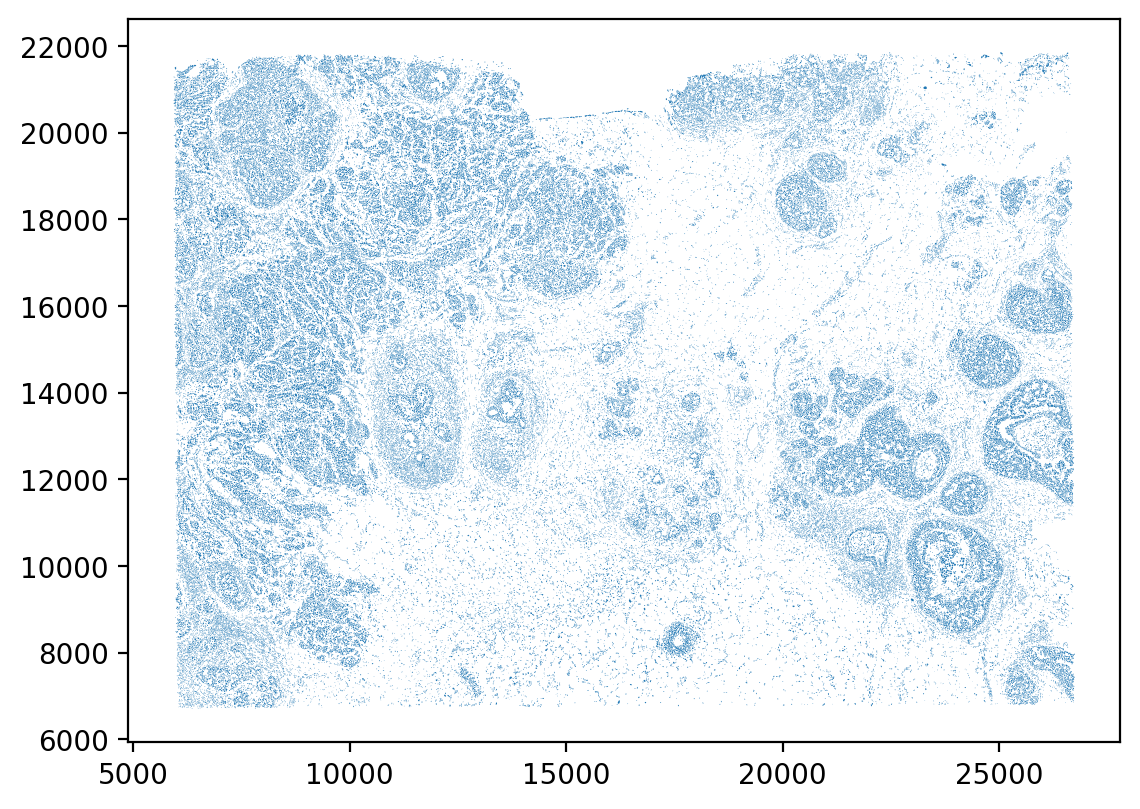

In [100]:
merged_gdf.plot()

In [219]:
merged_gdf_no_clusters = merged_gdf.drop(columns=['clusters'])

In [220]:
import sys
sys.path.append('../src/utils')
import os

# Importing importlib for module reloading
import importlib
import image_cropp_utils

# Reloading the module
importlib.reload(image_cropp_utils)

from image_cropp_utils import load_dataframe

In [221]:
cells_data = load_dataframe('../data/xenium/outs/cells.parquet')

In [222]:
cells_data

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  
0        58.387031     26.642188  
1       197.016719     42.130781  
2        16.256250     12.688906  
3        42.311406     10.069844  
4       107.652500     37.479688  
...            ...           ...  
167775  220.452813     60.599688  
167776   37.389375     25.242344  
167777  287.058281     86.700000  
167778  235.354375     25.197188  
167779  270.079531    111.806875  

[167780 rows x 9 columns]

In [223]:
import numpy as np
transform_matrix = np.array([
    [1.7125010585876286, 0.008345081015717404, -10397.19948741904],
    [0.008345081015717404, -1.7125010585876286, 37211.538978661185],
    [0, 0, 1]
])

# Get the inverse matrix
transform_matrix_inv = np.linalg.inv(transform_matrix)

# Extract coordinates and apply scaling
coords = cells_data[['x_centroid', 'y_centroid']].values
micron_to_pixel = 0.2125  # Microns per pixel
coords_scaled = coords / micron_to_pixel

# Function to transform coordinates
def transform_coordinates(coords, transform_matrix):
    coords = np.hstack((coords, np.ones((len(coords), 1))))
    transformed_coords = np.dot(transform_matrix, coords.T).T
    # Return only the x and y coordinates
    return transformed_coords[:, :2]

# Apply the transformation to the scaled coordinates
transformed_coords = transform_coordinates(coords_scaled, transform_matrix_inv)

# Update the DataFrame with the transformed coordinates
cells_data[['x_location_transformed', 'y_location_transformed']] = transformed_coords

In [224]:
from shapely.geometry import Polygon, Point
# Create a GeoDataFrame from cells_data
geometry = [Point(xy) for xy in zip(cells_data['x_location_transformed'], cells_data['y_location_transformed'])]
cells_gdf = gpd.GeoDataFrame(cells_data, geometry=geometry)
cells_gdf.crs = None

In [225]:
cells_gdf

cell_id   x_centroid   y_centroid  transcript_counts   
0             1   847.259912   326.191365                 28  \
1             2   826.341995   328.031830                 94   
2             3   848.766919   331.743187                  9   
3             4   824.228409   334.252643                 11   
4             5   841.357538   332.242505                 48   
...         ...          ...          ...                ...   
167775   167776  7455.475342  5114.875415                229   
167776   167777  7483.727051  5111.477490                 79   
167777   167778  7470.159424  5119.132056                397   
167778   167779  7477.737207  5128.712817                117   
167779   167780  7489.376562  5123.197778                378   

        control_probe_counts  control_codeword_counts  total_counts   
0                          1                        0            29  \
1                          0                        0            94   
2                          0                        0             9   
3                          0                        0            11   
4                          0                        0            48   
...                      ...                      ...           ...   
167775                     1                        0           230   
167776                     0                        0            79   
167777                     0                        0           397   
167778                     0                        0           117   
167779                     0                        0           378   

         cell_area  nucleus_area  x_location_transformed   
0        58.387031     26.642188             8297.871957  \
1       197.016719     42.130781             8240.416393   
2        16.256250     12.688906             8302.087393   
3        42.311406     10.069844             8234.691783   
4       107.652500     37.479688             8281.733889   
...            ...           ...                     ...   
167775  220.452813     60.599688            26520.667780   
167776   37.389375     25.242344            26598.254969   
167777  287.058281     86.700000            26561.075074   
167778  235.354375     25.197188            26582.026307   
167779  270.079531    111.806875            26613.936167   

        y_location_transformed                    geometry  
0                 20873.427800  POINT (8297.872 20873.428)  
1                 20868.090296  POINT (8240.416 20868.090)  
2                 20858.192164  POINT (8302.087 20858.192)  
3                 20850.967862  POINT (8234.692 20850.968)  
4                 20856.720876  POINT (8281.734 20856.721)  
...                        ...                         ...  
167775             7803.121686  POINT (26520.668 7803.122)  
167776             7812.837128  POINT (26598.255 7812.837)  
167777             7791.621519  POINT (26561.075 7791.622)  
167778             7765.396076  POINT (26582.026 7765.396)  
167779             7780.706674  POINT (26613.936 7780.707)  

[167780 rows x 12 columns]

<Axes: >

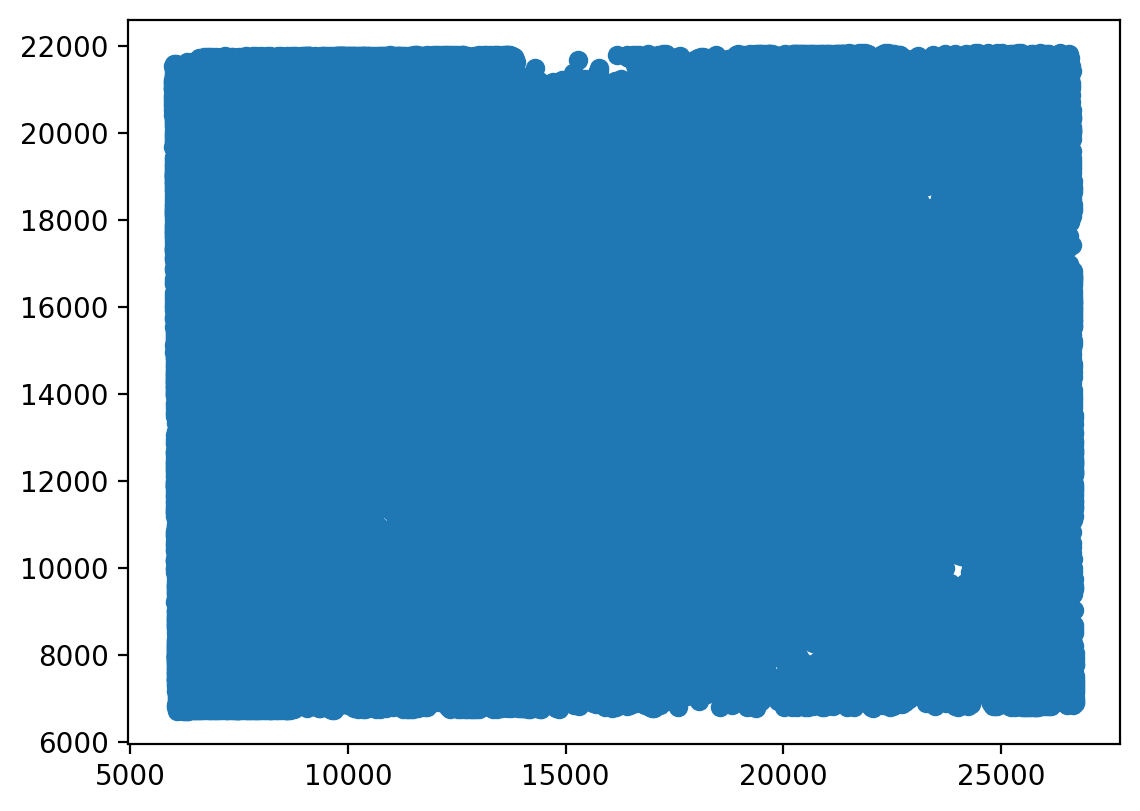

In [108]:
cells_gdf.plot()

In [226]:
# Perform spatial join
joined = gpd.sjoin(merged_gdf_no_clusters, cells_gdf, how='left', predicate='intersects')

<Axes: >

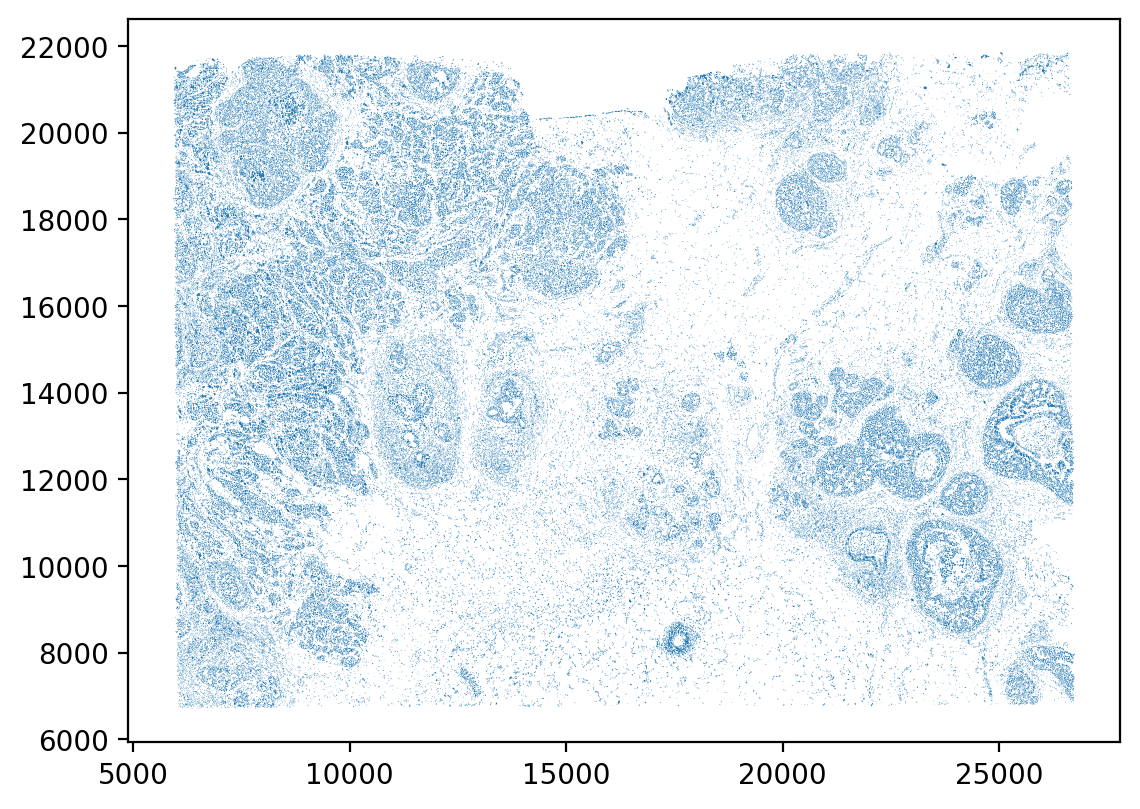

In [110]:
joined.plot()

In [111]:
joined

id                                           geometry   
6224      ID_6225  POLYGON ((7147.756 6836.000, 7147.470 6839.077...  \
6231      ID_6232  POLYGON ((6280.575 6964.000, 6280.311 6965.653...   
6234      ID_6235  POLYGON ((7205.946 6740.000, 7205.587 6741.907...   
6248      ID_6249  POLYGON ((6448.833 7252.000, 6448.276 7253.646...   
6252      ID_6253  POLYGON ((6924.299 7188.000, 6923.439 7190.275...   
...           ...                                                ...   
215214  ID_215215  POLYGON ((24364.991 21268.000, 24365.422 21269...   
215215  ID_215216  POLYGON ((25931.394 21776.000, 25931.607 21776...   
215217  ID_215218  POLYGON ((26654.858 21128.000, 26654.669 21128...   
215218  ID_215219  POLYGON ((25631.472 21608.000, 25631.918 21608...   
215220  ID_215221  POLYGON ((24879.726 21156.000, 24880.376 21156...   

                           centroid  index_right  cell_id  x_centroid   
6224      POINT (7131.478 6837.067)      42284.0  42285.0  399.355255  \
6231      POINT (6272.475 6965.052)      42966.0  42967.0   82.964026   
6234      POINT (7196.765 6739.273)          NaN      NaN         NaN   
6248      POINT (6439.568 7250.783)      43061.0  43062.0  145.100730   
6252      POINT (6912.052 7187.833)      42582.0  42583.0  318.665202   
...                             ...          ...      ...         ...   
215214  POINT (24360.196 21269.948)          NaN      NaN         NaN   
215215  POINT (25925.449 21772.255)          NaN      NaN         NaN   
215217  POINT (26647.682 21130.420)          NaN      NaN         NaN   
215218  POINT (25628.552 21609.456)          NaN      NaN         NaN   
215220  POINT (24874.741 21152.699)          NaN      NaN         NaN   

         y_centroid  transcript_counts  control_probe_counts   
6224    5437.458716              592.0                   0.0  \
6231    5382.626245              173.0                   0.0   
6234            NaN                NaN                   NaN   
6248    5281.886304              108.0                   0.0   
6252    5303.403174              252.0                   1.0   
...             ...                ...                   ...   
215214          NaN                NaN                   NaN   
215215          NaN                NaN                   NaN   
215217          NaN                NaN                   NaN   
215218          NaN                NaN                   NaN   
215220          NaN                NaN                   NaN   

        control_codeword_counts  total_counts   cell_area  nucleus_area   
6224                        0.0         592.0  398.142656    147.525469  \
6231                        0.0         173.0  179.405781     55.813125   
6234                        NaN           NaN         NaN           NaN   
6248                        0.0         108.0  110.632812     36.079844   
6252                        0.0         253.0  150.280000     75.320625   
...                         ...           ...         ...           ...   
215214                      NaN           NaN         NaN           NaN   
215215                      NaN           NaN         NaN           NaN   
215217                      NaN           NaN         NaN           NaN   
215218                      NaN           NaN         NaN           NaN   
215220                      NaN           NaN         NaN           NaN   

        x_location_transformed  y_location_transformed  
6224               7135.520510             6822.211526  
6231               6265.376854             6968.648654  
6234                       NaN                     NaN  
6248               6434.772936             7246.303336  
6252               6911.997752             7189.501397  
...                        ...                     ...  
215214                     NaN                     NaN  
215215                     NaN                     NaN  
215217                     NaN                     NaN  
215218                     NaN   

In [227]:
filtered_joined = joined[~joined['index_right'].isna()]

In [228]:
filtered_joined

id                                           geometry   
6224      ID_6225  POLYGON ((7147.756 6836.000, 7147.470 6839.077...  \
6231      ID_6232  POLYGON ((6280.575 6964.000, 6280.311 6965.653...   
6248      ID_6249  POLYGON ((6448.833 7252.000, 6448.276 7253.646...   
6252      ID_6253  POLYGON ((6924.299 7188.000, 6923.439 7190.275...   
6264      ID_6265  POLYGON ((6230.013 7178.000, 6229.209 7179.832...   
...           ...                                                ...   
215092  ID_215093  POLYGON ((24737.147 21370.000, 24735.887 21370...   
215136  ID_215137  POLYGON ((25077.814 21644.000, 25078.741 21647...   
215139  ID_215140  POLYGON ((24877.148 21714.000, 24876.717 21714...   
215150  ID_215151  POLYGON ((26540.023 21122.000, 26539.981 21122...   
215172  ID_215173  POLYGON ((24196.427 20768.000, 24197.074 20769...   

              area                     centroid  index_right   cell_id   
6224    989.890053    POINT (7131.478 6837.067)      42284.0   42285.0  \
6231    372.125690    POINT (6272.475 6965.052)      42966.0   42967.0   
6248    288.273555    POINT (6439.568 7250.783)      43061.0   43062.0   
6252    527.311285    POINT (6912.052 7187.833)      42582.0   42583.0   
6264    227.866833    POINT (6220.372 7177.860)      43041.0   43042.0   
...            ...                          ...          ...       ...   
215092   94.885940  POINT (24733.210 21368.687)     150717.0  150718.0   
215136  419.760136  POINT (25063.022 21643.064)     151002.0  151003.0   
215139  197.126647  POINT (24867.313 21715.517)     150982.0  150983.0   
215150  199.798590  POINT (26532.022 21122.927)     166601.0  166602.0   
215172  182.948379  POINT (24188.428 20761.430)     151067.0  151068.0   

         x_centroid   y_centroid  transcript_counts  control_probe_counts   
6224     399.355255  5437.458716              592.0                   0.0  \
6231      82.964026  5382.626245              173.0                   0.0   
6248     145.100730  5281.886304              108.0                   0.0   
6252     318.665202  5303.403174              252.0                   1.0   
6264      64.706159  5305.564697               97.0                   0.0   
...             ...          ...                ...                   ...   
215092  6830.294116   176.534129              399.0                   1.0   
215136  6949.038037    78.380879              193.0                   0.0   
215139  6879.694141    47.338940               51.0                   0.0   
215150  7482.108398   267.412054              320.0                   0.0   
215172  6629.117627   396.159558              463.0                   0.0   

        control_codeword_counts  total_counts    cell_area  nucleus_area   
6224                        0.0         592.0   398.142656    147.525469  \
6231                        0.0         173.0   179.405781     55.813125   
6248                        0.0         108.0   110.632812     36.079844   
6252                        0.0         253.0   150.280000     75.320625   
6264                        0.0          97.0   108.962031     28.854844   
...                         ...           ...          ...           ...   
215092                      0.0         400.0  1064.468281     23.390937   
215136                      0.0         193.0   282.226562     13.953281   
215139                      0.0          51.0    86.158125     18.288281   
215150                      0.0         320.0   626.949375     40.008437   
215172                      0.0         463.0   585.134688     54.322969   

        x_location_transformed  y_location_transformed  
6224               7135.520510             6822.211526  
6231               6265.376854             6968.648654  
6248               6434.772936             7246.303336  
6252               6911.997752             7189.501397  
6264               6214.174281             7180.161100  
...                        ...                     ...  
215092            24736.

<Axes: >

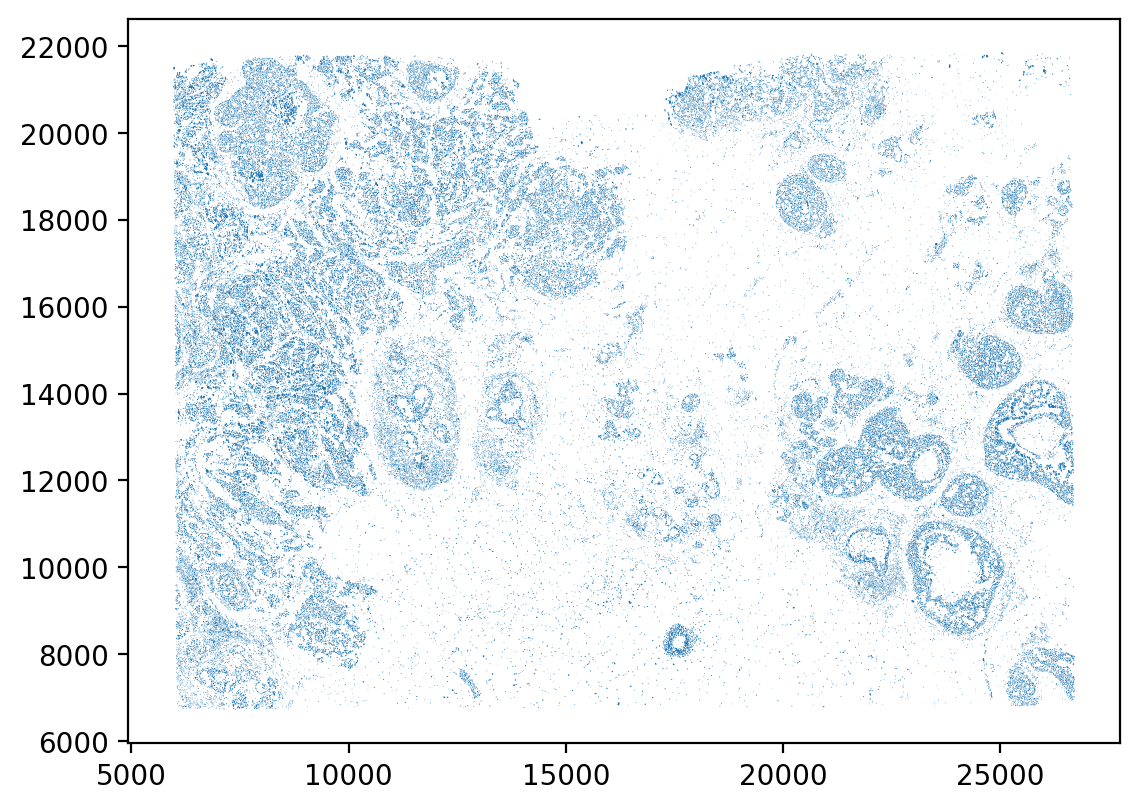

In [229]:
filtered_joined.plot()

In [230]:
import pandas as pd

# Group by 'id' and aggregate 'cell_id' by joining with a comma for duplicates
aggregated_df = filtered_joined.groupby('id').agg({
    'geometry': 'first',  # Keep the first geometry (assuming it's the same for duplicates)
    'cell_id': lambda x: ','.join(x.astype(str))  # Combine cell_id values with a comma
}).reset_index()

aggregated_df

id                                           geometry   
0      ID_100000  POLYGON ((21176.627 13282.000, 21176.226 13282...  \
1      ID_100002  POLYGON ((23761.492 11064.000, 23757.712 11065...   
2      ID_100004  POLYGON ((23474.280 12904.000, 23474.310 12905...   
3      ID_100005  POLYGON ((21813.596 11330.000, 21814.073 11331...   
4      ID_100007  POLYGON ((23127.516 12532.000, 23127.402 12533...   
...          ...                                                ...   
88470   ID_99987  POLYGON ((22340.075 13966.000, 22339.938 13966...   
88471   ID_99989  POLYGON ((21563.787 10904.000, 21563.855 10905...   
88472   ID_99991  POLYGON ((23375.426 12936.000, 23375.143 12937...   
88473   ID_99995  POLYGON ((23854.037 11416.000, 23853.864 11417...   
88474   ID_99999  POLYGON ((21481.133 11146.000, 21480.527 11146...   

               cell_id  
0             128986.0  
1             144585.0  
2             140484.0  
3             131974.0  
4      11427.0,11428.0  
...                ...  
88470         142942.0  
88471         131200.0  
88472         140498.0  
88473         143461.0  
88474         131635.0  

[88475 rows x 3 columns]

In [231]:
# Count the number of cell_ids by splitting on the comma and checking the length
aggregated_df['cell_id_count'] = aggregated_df['cell_id'].apply(lambda x: len(x.split(',')))

# Filter the rows where the count of cell_ids is greater than 1
rows_with_multiple_cell_ids = aggregated_df[aggregated_df['cell_id_count'] > 1]

# Count how many such rows exist
num_rows_with_multiple_cell_ids = rows_with_multiple_cell_ids.shape[0]

# Display the result
print(f"Number of rows with more than one cell_id: {num_rows_with_multiple_cell_ids}")


Number of rows with more than one cell_id: 4489


In [232]:
filtered_df = aggregated_df[aggregated_df['cell_id_count'] <= 1]

# Drop the 'cell_id_count' column if you no longer need it
filtered_df = filtered_df.drop(columns=['cell_id_count'])

# Display the resulting DataFrame
filtered_df

id                                           geometry   cell_id
0      ID_100000  POLYGON ((21176.627 13282.000, 21176.226 13282...  128986.0
1      ID_100002  POLYGON ((23761.492 11064.000, 23757.712 11065...  144585.0
2      ID_100004  POLYGON ((23474.280 12904.000, 23474.310 12905...  140484.0
3      ID_100005  POLYGON ((21813.596 11330.000, 21814.073 11331...  131974.0
5      ID_100008  POLYGON ((22299.687 10864.000, 22299.217 10865...  145665.0
...          ...                                                ...       ...
88470   ID_99987  POLYGON ((22340.075 13966.000, 22339.938 13966...  142942.0
88471   ID_99989  POLYGON ((21563.787 10904.000, 21563.855 10905...  131200.0
88472   ID_99991  POLYGON ((23375.426 12936.000, 23375.143 12937...  140498.0
88473   ID_99995  POLYGON ((23854.037 11416.000, 23853.864 11417...  143461.0
88474   ID_99999  POLYGON ((21481.133 11146.000, 21480.527 11146...  131635.0

[83986 rows x 3 columns]

In [233]:
filtered_gdf = gpd.GeoDataFrame(filtered_df, geometry='geometry')

<Axes: >

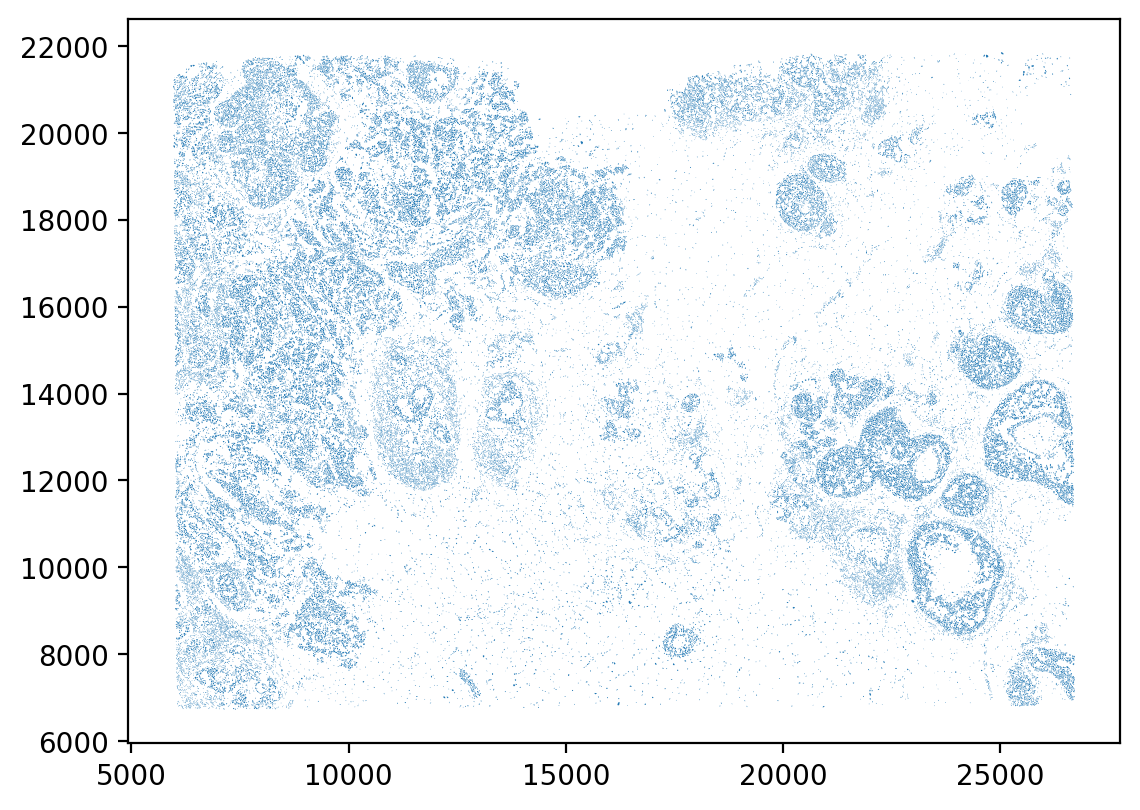

In [234]:
filtered_gdf.plot()

In [235]:
# important use as gdf for id mapping
filtered_gdf.to_file("../data/xenium/outs/final_adatas/stardist_gaussian.geojson", driver='GeoJSON')

In [236]:
grouped_filtered_adata

AnnData object with n_obs × n_vars = 147621 × 541
    obs: 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'clusters'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'clusters'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [237]:
import anndata as ad

# Extract the ids from filtered_gdf
valid_ids = filtered_gdf['id'].tolist()

# Filter the rows in grouped_filtered_adata based on the valid ids
filtered_grouped_adata = grouped_filtered_adata[grouped_filtered_adata.obs['id'].isin(valid_ids)]


In [238]:
filtered_grouped_adata

View of AnnData object with n_obs × n_vars = 83986 × 541
    obs: 'id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'clusters'
    var: 'transcript_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'clusters'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [239]:
filtered_grouped_adata.write("../data/xenium/improved_outs/grouped_filtered_stardist_gaussian_adata.h5ad")
# IMPORTANT you will need this as ADATA